In [ ]:
!pip install geopandas
!pip install geopy
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy
# Importing the geodesic module from the library
from geopy.distance import geodesic
from shapely.geometry import Point
import matplotlib.pyplot as plt

#for large dataset
import dask.dataframe as dd
from multiprocessing import Pool

try: #spelling depends on enviroment version 
    import urllib2 as urllib #URL handling module
except ImportError:
    import urllib.request as urllib
import json
import os

## New York Restaurant Inspection

In [ ]:
#DOHMH New York City Restaurant Inspection
!curl https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD > Inspection_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 85.1M    0 85.1M    0     0  6424k      0 --:--:--  0:00:13 --:--:-- 7453k


In [ ]:
rest_data = pd.read_csv('Inspection_data.csv')
print('Original shape:',rest_data.shape)
# rest_data.head(5)

rest_data['INSPECTION DATE'] = pd.to_datetime(rest_data['INSPECTION DATE'])
# rest_data['inspection_year'] = rest_data['INSPECTION DATE'].dt.year
rest_data = rest_data[rest_data['INSPECTION DATE'].dt.year!=1900]
#only study inspection after 2022
rest_data = rest_data[rest_data['INSPECTION DATE'].dt.year>=2022]
#fliter out record without score
rest_data = rest_data[~rest_data.SCORE.isnull()]
rest_data = rest_data[~rest_data.Latitude.isnull()]
rest_data = rest_data[~rest_data['VIOLATION CODE'].isnull()]
rest_data = rest_data[~rest_data['GRADE DATE'].isnull()]
rest_data = rest_data[rest_data.Latitude!=0]
#RECORD DATE: indicate the current day
#GRADE DATE == INSPECTION DATE
exclude_col = ['PHONE','BIN','STREET','Location Point1','RECORD DATE','Community Board','Council District','BUILDING','ZIPCODE','GRADE DATE']  #'BBL',
#nta > census tract
rest_data = rest_data.loc[:, ~rest_data.columns.isin(exclude_col)]
#convert to geopandas
LatList = rest_data.Latitude.tolist()
LonList = rest_data.Longitude.tolist()
rest_data['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(rest_data))]
rest_data = gpd.GeoDataFrame(rest_data,crs={'init':'epsg:4326'}) #use projection 
rest_data.to_crs(epsg=4326,inplace=True)

print('After Cleaning',rest_data.shape)
rest_data = rest_data.reset_index()
rest_data.head()

Original shape: (205686, 27)


/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


After Cleaning (54862, 17)


,index,CAMIS,DBA,BORO,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Latitude,Longitude,Census Tract,NTA,geometry
0,107,50121030,Popeye's,Brooklyn,Chicken,2022-07-05,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,7.0,A,Pre-permit (Operational) / Initial Inspection,40.687952,-73.980269,3300.0,BK68,POINT (-73.98027 40.68795)
1,111,41273383,LA BELLA PIZZERIA,Brooklyn,Pizza,2022-11-15,Violations were cited in the following area(s).,04M,Live roaches in facility's food or non-food area.,Critical,12.0,A,Cycle Inspection / Re-inspection,40.605075,-73.997749,28800.0,BK28,POINT (-73.99775 40.60507)
2,144,40997900,MR WASABI,Queens,Japanese,2022-03-30,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,9.0,A,Cycle Inspection / Initial Inspection,40.762200,-73.770309,146700.0,QN46,POINT (-73.77031 40.76220)
3,160,40369461,CAFE UN DEUX TROIS,Manhattan,French,2023-03-08,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,27.0,B,Cycle Inspection / Re-inspection,40.756484,-73.983977,11900.0,MN17,POINT (-73.98398 40.75648)
4,172,41096117,KOI,Manhattan,Japanese,2022-09-15,Violations were cited in the following area(s).,09B,Thawing procedure improper.,Not Critical,12.0,A,Cycle Inspection / Initial Inspection,40.753053,-73.983892,8400.0,MN17,POINT (-73.98389 40.75305)


<Axes: >

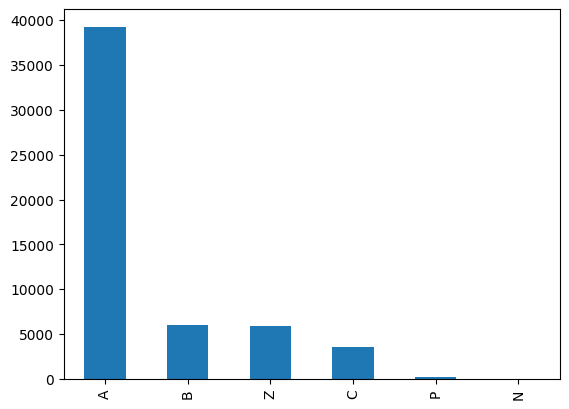

In [ ]:
rest_data['GRADE'].value_counts().plot(kind='bar')
# rest_data[rest_data['GRADE']=='P']

In [ ]:
#save as shapefile
rest_data = pd.read_csv('rest_data_2Feature_w_BBL.csv')
LatList = rest_data.Latitude.tolist()
LonList = rest_data.Longitude.tolist()
rest_data['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(rest_data))]
rest_data = gpd.GeoDataFrame(rest_data,crs={'init':'epsg:4326'}) #use projection 
rest_data.to_crs(epsg=4326,inplace=True)

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# rest_data.to_file('rest_data_Feature_w_BBL.shp') 

## Food Scrap Drop off Location

In [ ]:
##NTA
nta_data = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=Shapefile')
nta_data = nta_data.sort_values(by=['ntaname'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146k    0  146k    0     0   142k      0 --:--:--  0:00:01 --:--:--  142k


<ipython-input-6-4e1aaae4a5df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodDO['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(foodDO))]
/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Object ID,geometry
1,6777,POINT (-73.98473 40.67271)
4,7046,POINT (-73.92561 40.76147)
9,6716,POINT (-74.01488 40.71839)
11,7184,POINT (-74.06299 40.59558)
12,7096,POINT (-73.87918 40.83990)
...,...,...
464,7073,POINT (-73.95262 40.64721)
465,6930,POINT (-73.92693 40.70543)
468,6847,POINT (-73.93295 40.67623)
470,6715,POINT (-74.01716 40.70676)


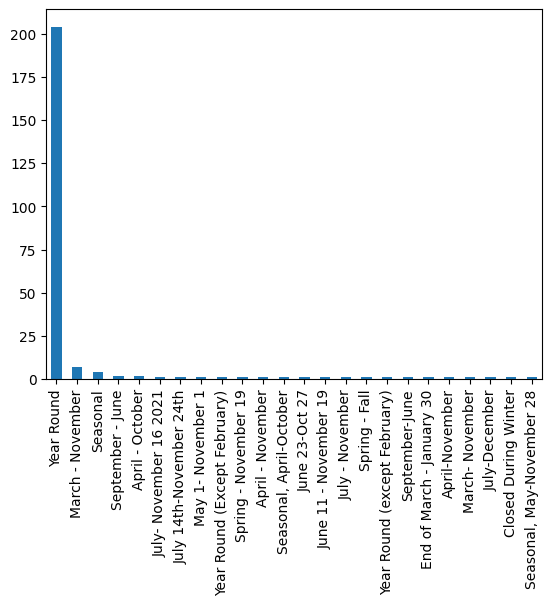

In [ ]:
#Food Scrap Drop-Off Locations in NYC
!curl https://data.cityofnewyork.us/api/views/if26-z6xq/rows.csv?accessType=DOWNLOAD > foodDO.csv
foodDO = pd.read_csv('foodDO.csv')
foodDO = foodDO[~foodDO['Location Point'].isnull()]
foodDO['Open_Month'].value_counts().plot(kind='bar')
#ignore the seasonal/periodical drop-off location
foodDO = foodDO[foodDO['Open_Month']=='Year Round']
##convert to geopandas
LatList = foodDO.Latitude.tolist()
LonList = foodDO.Longitude.tolist()
foodDO['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(foodDO))]
foodDO = gpd.GeoDataFrame(foodDO[['Object ID','geometry']],crs={'init':'epsg:4326'})
foodDO

In [ ]:
FoodDOLoc = foodDO.geometry.tolist()
def returnValue(record):
    lat = record['Latitude']
    lon = record['Longitude']
    return (len([ 1 for i in FoodDOLoc if geodesic((lon,lat),(i.x,i.y)).km<=0.3 ]))

chunk = []
result = []
# read 100000 rows in each chunk
chunksize = 1000
pool = Pool(8)
for i, line in rest_data.iterrows():
    rowdata = line.to_dict()
    if (i % chunksize == 0 and i > 0):
        print(i)
        chunkOutput = pool.map(returnValue,chunk)
        result += chunkOutput
        chunk = []
        
    chunk.append(rowdata)

#for the remaining data
chunkOutput = pool.map(returnValue,chunk)
result += chunkOutput
pool.close()

rest_data['FoodDOSite_Within_300m'] = result

In [ ]:
rest_data.head()

,index,CAMIS,DBA,BORO,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Latitude,Longitude,Census Tract,NTA,geometry,FoodDOSite_Within_300m
0,107,50121030,Popeye's,Brooklyn,Chicken,2022-07-05,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,7.0,A,Pre-permit (Operational) / Initial Inspection,40.687952,-73.980269,3300.0,BK68,POINT (-73.98027 40.68795),0
1,111,41273383,LA BELLA PIZZERIA,Brooklyn,Pizza,2022-11-15,Violations were cited in the following area(s).,04M,Live roaches in facility's food or non-food area.,Critical,12.0,A,Cycle Inspection / Re-inspection,40.605075,-73.997749,28800.0,BK28,POINT (-73.99775 40.60507),1
2,144,40997900,MR WASABI,Queens,Japanese,2022-03-30,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,9.0,A,Cycle Inspection / Initial Inspection,40.762200,-73.770309,146700.0,QN46,POINT (-73.77031 40.76220),0
3,160,40369461,CAFE UN DEUX TROIS,Manhattan,French,2023-03-08,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,27.0,B,Cycle Inspection / Re-inspection,40.756484,-73.983977,11900.0,MN17,POINT (-73.98398 40.75648),0
4,172,41096117,KOI,Manhattan,Japanese,2022-09-15,Violations were cited in the following area(s).,09B,Thawing procedure improper.,Not Critical,12.0,A,Cycle Inspection / Initial Inspection,40.753053,-73.983892,8400.0,MN17,POINT (-73.98389 40.75305),0


## Subway Station
how many station around a restuarant with a specific distance (300 m)

In [ ]:
#subway station
subway = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile')
subway.to_crs(epsg=4326,inplace=True)  #convert to projection 
subway = subway[['name','geometry']]
subway.head()

,name,geometry
0,Astor Pl,POINT (-73.99107 40.73005)
1,Canal St,POINT (-74.00019 40.71880)
2,50th St,POINT (-73.98385 40.76173)
3,Bergen St,POINT (-73.97500 40.68086)
4,Pennsylvania Ave,POINT (-73.89489 40.66471)


In [ ]:
##look for multiprocessing 

SubwayLoc = subway.geometry.tolist()
def returnValue(record):
    lat = record['Latitude']
    lon = record['Longitude']
    return (len([ 1 for i in SubwayLoc if geodesic((lon,lat),(i.x,i.y)).km<=0.3 ]))

chunk = []
withinDist = []
# read 100000 rows in each chunk
chunksize = 1000
pool = Pool(8)
for i, line in rest_data.iterrows():
    rowdata = line.to_dict()
    if (i % chunksize == 0 and i > 0):
        print(i)
        chunkOutput = pool.map(returnValue,chunk)
        withinDist += chunkOutput
        chunk = []
        
    chunk.append(rowdata)

#for the remaining data
chunkOutput = pool.map(returnValue,chunk)
withinDist += chunkOutput
pool.close()

rest_data['SubwayWithin_300m'] = withinDist

In [ ]:
rest_data.head()

,index,CAMIS,DBA,BORO,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,INSPECTION TYPE,Latitude,Longitude,Census Tract,NTA,geometry,FoodDOSite_Within_300m,SubwayWithin_300m
0,107,50121030,Popeye's,Brooklyn,Chicken,2022-07-05,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,7.0,A,Pre-permit (Operational) / Initial Inspection,40.687952,-73.980269,3300.0,BK68,POINT (-73.98027 40.68795),0,3
1,111,41273383,LA BELLA PIZZERIA,Brooklyn,Pizza,2022-11-15,Violations were cited in the following area(s).,04M,Live roaches in facility's food or non-food area.,Critical,12.0,A,Cycle Inspection / Re-inspection,40.605075,-73.997749,28800.0,BK28,POINT (-73.99775 40.60507),1,1
2,144,40997900,MR WASABI,Queens,Japanese,2022-03-30,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,9.0,A,Cycle Inspection / Initial Inspection,40.762200,-73.770309,146700.0,QN46,POINT (-73.77031 40.76220),0,0
3,160,40369461,CAFE UN DEUX TROIS,Manhattan,French,2023-03-08,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,27.0,B,Cycle Inspection / Re-inspection,40.756484,-73.983977,11900.0,MN17,POINT (-73.98398 40.75648),0,6
4,172,41096117,KOI,Manhattan,Japanese,2022-09-15,Violations were cited in the following area(s).,09B,Thawing procedure improper.,Not Critical,12.0,A,Cycle Inspection / Initial Inspection,40.753053,-73.983892,8400.0,MN17,POINT (-73.98389 40.75305),0,6


In [ ]:
rest_data.to_csv('rest_data_2Feature.csv')

## Other Census Data (Demography and Income)
Current Data: population and income based on ACS data in 2020

In [ ]:
#census data
# !pip install census
# !pip install us
from census import Census
from us import states

In [ ]:
#how to access acs: https://pygis.io/docs/d_access_census.html

#request a key: https://api.census.gov/data/key_signup.html
c = Census("9539dae04d950aa6ea780553e4526f196063785c")
#list of variables in ACS: https://api.census.gov/data/2019/acs/acs5/variables.html
# Income Section: https://api.census.gov/data/2011/acs/acs5/groups/C17002.html
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# county_fips:{Brooklyn/Kings: 36047, Manhattan/New York: 36061, Queens/Queens:36081, 
                    # Staten Island/Richmond:36085, Bronx/Bronx: 36005}
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'B01003_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2020)
# Create a dataframe from the census data
ny_popIncome_df = pd.DataFrame(ny_census)

In [ ]:
countyNYC = ['047', '061', '081', '085', '005']
ny_popIncome_df = ny_popIncome_df[ny_popIncome_df.county.isin(countyNYC)]

## Rodent Inspection
Only check record after 2022

In [ ]:
# !curl https://data.cityofnewyork.us/api/views/p937-wjvj/rows.csv?accessType=DOWNLOAD > rodent.csv
'''
INSPECTION_TYPE:
Initial Inspection - Inspection conducted in response to a 311 complaint;
Compliance Inspection - If a property fails its initial inspection, the Health Department will conduct a follow up (Compliance) inspection
Baiting - Application of rodenticide,
Stoppage – Sealing of holes and cracks allowing free movement of pests.

RESULT:
Active Rat Signs (ARS) - ARS include any of six different signs: 1) fresh tracks, 2) fresh droppings, 3) active burrows,
                                                                4) active runways and rub marks, 5) fresh gnawing marks, and 6) live rats.
Problem Conditions - Problem conditions include garbage
(poor containerization of food waste resulting in the feeding
of rats), harborage (clutter and dense vegetation promoting
the nesting of rats), and mice
'''
rodent = pd.read_csv('rodent.csv')
rodent.head(3)

,INSPECTION_TYPE,JOB_TICKET_OR_WORK_ORDER_ID,JOB_ID,JOB_PROGRESS,BBL,BORO_CODE,BLOCK,LOT,HOUSE_NUMBER,STREET_NAME,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE,BOROUGH,INSPECTION_DATE,RESULT,APPROVED_DATE,LOCATION
0,Initial,13407377,PC7882384,1,3.019260e+09,3,1926,10,NaN,NaN,11205.0,NaN,NaN,NaN,NaN,Brooklyn,06/09/2022 01:54:54 PM,Passed,06/13/2022 11:08:40 AM,NaN
1,Initial,13579860,PC8047096,1,1.004530e+09,1,453,34,NaN,NaN,10003.0,NaN,NaN,NaN,NaN,Manhattan,02/13/2023 01:40:15 PM,Rat Activity,02/14/2023 01:55:23 PM,NaN
2,BAIT,2799143,PC7647263,4,4.036190e+09,4,3619,1,NaN,NaN,11385.0,NaN,NaN,NaN,NaN,Queens,03/05/2021 10:40:58 AM,Bait applied,03/08/2021 10:47:56 AM,NaN


In [ ]:
#look for dask.dataframe.read_csv
#reference: https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html
rodent = dd.read_csv('rodent.csv')
rodent = rodent[['INSPECTION_TYPE','JOB_PROGRESS','BORO_CODE','BLOCK','LOT','ZIP_CODE','INSPECTION_DATE', 'RESULT', 'APPROVED_DATE','LOCATION']]
BadSign = ['Rat Activity','Bait applied','Failed for Other R']
rodent = rodent[rodent.RESULT.isin(BadSign)]
rodent = rodent[~rodent.LOCATION.isnull()]
rodent = rodent[~rodent.BLOCK.isnull()]
rodent = rodent[~rodent.RESULT.isnull()]
rodent['INSPECTION_DATE'] = dd.to_datetime(rodent['INSPECTION_DATE'],errors = 'coerce')
rodent['APPROVED_DATE'] = dd.to_datetime(rodent['APPROVED_DATE'],errors = 'coerce')

In [ ]:
rodent_after2021 = rodent[(rodent.INSPECTION_DATE.dt.year>=2021) & (rodent.INSPECTION_DATE.dt.year<=2023)]
rodent_after2021 = rodent_after2021[~rodent_after2021.APPROVED_DATE.isnull()]
rodent_after2021 = rodent_after2021[~rodent_after2021.ZIP_CODE.isnull()]
# rodent_after2021['BBL'] = rodent_after2021['BBL'].astype('int')   #npartition=8

In [ ]:
# convert the Dask DataFrame into a pandas DataFrame
# rodent_after2021_df = rodent_after2021.compute()
# rodent_after2021.columns
rodent_after2021_df = pd.DataFrame(rodent_after2021)
rodent_after2021_df
rodent_after2021_df.columns = rodent_after2021.columns.tolist()
rodent_after2021_df.to_csv('rodent_after2021.csv')

,0,1,2,3,4,5,6,7,8,9
0,BAIT,6,1,1643,35,10029.0,2023-03-10 10:00:10,Bait applied,2023-03-10 14:37:30,"(40.797536495796, -73.940326439202)"
1,Compliance,2,3,3247,26,11237.0,2023-03-08 12:45:49,Rat Activity,2023-03-10 11:52:21,"(40.702001957764, -73.921481404014)"
2,Initial,1,1,1130,1,10024.0,2023-03-03 15:25:12,Rat Activity,2023-03-10 11:42:40,"(40.781305212452, -73.97225400025)"
3,Initial,1,1,2157,75,10033.0,2023-03-09 10:35:33,Failed for Other R,2023-03-10 09:20:21,"(40.85290347921, -73.930654023169)"
4,Initial,1,2,3031,145,10458.0,2023-03-09 14:22:36,Rat Activity,2023-03-10 11:54:10,"(40.858608868253, -73.893571639919)"
...,...,...,...,...,...,...,...,...,...,...
182434,Initial,1,3,1068,23,11215.0,2022-03-22 10:05:00,Rat Activity,2022-03-23 13:40:24,"(40.672332481229, -73.972097631312)"
182435,Initial,1,1,1578,6,10028.0,2021-11-08 09:05:20,Rat Activity,2021-11-09 08:59:06,"(40.772503034358, -73.948981426982)"
182436,Initial,1,1,376,27,10009.0,2021-08-11 10:12:58,Rat Activity,2021-08-12 09:33:39,"(40.723504458855, -73.977527413236)"
182437,BAIT,1,2,3334,1,10467.0,2023-03-05 12:30:00,Bait applied,2023-03-09 08:03:49,"(40.872961969586, -73.880527796657)"


In [ ]:
# rest_data
#4/99999/9999
rest_data = rest_data[~rest_data.BBL.isnull()]
rest_data['BBL'] = rest_data['BBL'].astype('int')
rest_data['BBL'] = rest_data['BBL'].astype('str')

rodent_after2021_df['BLOCK'] = rodent_after2021_df['BLOCK'].astype('str')
rodent_after2021_df['BORO_CODE'] = rodent_after2021_df['BORO_CODE'].astype('str')
rodent_after2021_df['LOT'] = rodent_after2021_df['LOT'].astype('str')
rodent_after2021_df['BBL'] = rodent_after2021_df['BORO_CODE']+rodent_after2021_df['BLOCK'].apply(lambda x: x.zfill(5))+rodent_after2021_df['LOT'].apply(lambda x: x.zfill(4))

/usr/local/lib/python3.9/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
rodent_after2022_df = rodent_after2021_df[rodent_after2021_df.INSPECTION_DATE.dt.year >= 2022]
rodent_after2022_df.to_csv('rodent_after2022.csv')

In [ ]:
# rest_data.merge(rodent_after2021_df, on='BBL', how='left')
### date rodent inspection date have to prior to the restaurant inspection date
# Check Duplicate in restuarant data
# rest_data.duplicated().sum()
rest_rodent_data = rest_data.merge(rodent_after2022_df, on='BBL', how='left')

In [ ]:
exclude_col = ['Boro', 'Block','Lot','BORO_CODE', 'BLOCK', 'LOT','LOCATION','ZIP_CODE','APPROVED_DATE']  #'BBL',
#nta > census tract
rest_rodent_data = rest_rodent_data.loc[:, ~rest_rodent_data.columns.isin(exclude_col)]
rest_rodent_data.loc[rest_rodent_data['RESULT'].isnull(),'RESULT']='Passed'
from datetime import date
rest_rodent_data.loc[rest_rodent_data['INSPECTION_DATE'].isnull(),'INSPECTION_DATE']=date(2010, 1, 1)

In [ ]:
#### count rodent in each census tract
import requests
import zipfile


#https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

urllib.urlretrieve ("https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyct2020_23a.zip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')

nyct2020 = gpd.read_file("ZIPS/nyct2020_23a/nyct2020.shp")
nyct2020 = nyct2020[['CT2020','NTAName','NTA2020','CDTA2020','CDTANAME','geometry']]
nyct2020 = nyct2020.set_crs(epsg=2263)
nyct2020 = nyct2020.to_crs(epsg=4326)

In [ ]:
rodent_after2022_df = pd.read_csv('rodent_after2022.csv').iloc[:,1:]
rodent_after2022_df['INSPECTION_DATE'] = rodent_after2022_df['INSPECTION_DATE'].apply(lambda x: x.split()[0])
rodent_after2022_df = rodent_after2022_df.loc[:, ~rodent_after2022_df.columns.isin(['APPROVED_DATE'])]
#drop the record if inspection date and result are same
rodent_after2022_df = rodent_after2022_df.drop_duplicates(subset=['BBL','INSPECTION_DATE','RESULT'])
rodent_after2022_df['LATITUDE'] = rodent_after2022_df['LOCATION'].apply(lambda loc: str(loc.split(', ')[0].split('(')[1]) )
rodent_after2022_df['LONGITUDE'] = rodent_after2022_df['LOCATION'].apply(lambda loc: str(loc.split(', ')[1].split(')')[0]) )
#convert to geopandas
LatList = rodent_after2022_df.LATITUDE.tolist()
LonList = rodent_after2022_df.LONGITUDE.tolist()
rodent_after2022_df['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(rodent_after2022_df))]
rodent_after2022_gdf = gpd.GeoDataFrame(rodent_after2022_df) #use projection 

<ipython-input-49-0f80c6519d4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rodent_after2022_df['LATITUDE'] = rodent_after2022_df['LOCATION'].apply(lambda loc: str(loc.split(', ')[0].split('(')[1]) )
<ipython-input-49-0f80c6519d4c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rodent_after2022_df['LONGITUDE'] = rodent_after2022_df['LOCATION'].apply(lambda loc: str(loc.split(', ')[1].split(')')[0]) )


In [ ]:
rodent_after2022_gdf = rodent_after2022_gdf.sjoin(nyct2020, op='within', how='inner')
rodent_after2022_gdf.to_file('rodent_after2022_censusBlock.shp') 

<ipython-input-61-0d1e0c7520aa>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  rodent_after2022_gdf.to_file('rodent_after2022_censusBlock.shp')


In [ ]:
rodent_after2022_gdf.to_csv('rodent_after2022_censusBlock.csv')


## Social Mobility
Current data: at a taxi-zone level

In [ ]:
#social mobility
mobility=pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/Socio-mobility.csv",index_col=0)
#rename some of the columns for the sake of consistency and also to replace '-'
mobility.rename(columns={'mobile-device_spatial':'mobile','citibike_spatial':'citibike','sr311_spatial':'sr311','subway_spatial':'subway','taxi_spatial':'taxi','twitter_spatial':'twitter'})
mobility

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,...,unemployment_rate,percent_uninsured,mean_price_per_sqft,median_price_per_sqft,citibike_spatial,mobile-device_spatial,sr311_spatial,subway_spatial,taxi_spatial,twitter_spatial
tz,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,383102,0,0.0,95418,1546
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,6348,0,0.0,73,44
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,...,10.045116,8.402712,318.691787,315.104167,0,109300,700,225527.5,31960,480
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,...,9.031957,8.955406,NaN,NaN,31545,179644,399,0.0,178515,85
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,...,5.503406,3.673850,289.552591,276.162791,0,56271,490,0.0,3667,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,44064.0,20502.0,23562.0,17.150757,22.004275,34.482983,26.361984,21.362110,61.555919,4.416304,...,10.602008,10.301060,247.453128,243.542911,0,461017,1142,1065402.0,43841,274
260,45702.0,23401.0,22301.0,16.373437,19.598034,39.453075,24.575453,46.781322,1.444138,39.753184,...,6.819275,18.911168,443.492147,441.390182,0,353643,754,3635465.0,138882,725
261,4537.0,1889.0,2648.0,9.890110,35.564436,47.552448,6.993007,68.415252,2.689002,21.071192,...,3.000000,4.000000,NaN,NaN,19131,258407,323,6178926.0,225140,523


In [ ]:
mobility.columns

Index(['population', 'male', 'female', 'age_under_14', 'age_15_29',
       'age_30_54', 'age_55_over', 'white', 'black', 'asian', 'others',
       'two_or_more', 'less_high_school', 'high_school', 'college', 'bachelor',
       'graduate', 'median_income_households', 'median_income_families',
       'median_income_nonfamily', 'mean_income_households',
       'mean_income_families', 'mean_income_nonfamily',
       'percent_below_poverty', 'unemployment_rate', 'percent_uninsured',
       'mean_price_per_sqft', 'median_price_per_sqft', 'citibike_spatial',
       'mobile-device_spatial', 'sr311_spatial', 'subway_spatial',
       'taxi_spatial', 'twitter_spatial'],
      dtype='object')